<a href="https://colab.research.google.com/github/jdmartin86/winter-school-practical/blob/main/RL_Practical_2026_Openmind_Winter_School.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2026 Openmind Winter School Practical
Authors: John D. Martin (john.martin@openmindresearch.org), Shruti Mishra, Jordan Hoffmann

This assignment covers a number of important reinforcement learning concepts, algorithms, and phenomena. Students will observe the general interaction between a learning system and its environment. In addition, they will implement the classic algorithms SARSA and Q-Learning, for policy evaluation and control. Using experience in a small gridworld domain, students will observe how the presence of stochasticity influences step size sensitivity. The focus shifts in the latter part of the assignment to issues that arise under function approximation with a neural network. Using experience in a domain with continuous states and actions, students will observe how performance of the PPO algorithm changes with different architecture sizes.      



# Environment defintion

In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
import functools
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from matplotlib import colormaps

In [ ]:
#@title 5x5 GridWorld
class GridWorld:
  def __init__(self, stochastic=False, seed=0):
    self.stochastic = stochastic
    self.seed = seed

    self.num_rows = 5
    self.num_cols = 5
    self.num_actions = 4
    self.num_states = self.num_cols * self.num_rows

    self._rand = np.random.RandomState(self.seed)

    self._init_topology()
    self.counts = np.zeros(self.num_states)

  def _init_topology(self, initial_grid=None):
    # Assign the adjacency: [W, N, E, S]
    self.adjacency_list = np.array(
                          [[0,1,5,0],
                           [1,2,6,0],
                           [2,3,7,1],
                           [3,4,8,2],
                           [4,4,9,3],
                           [0,6,10,5],
                           [1,7,11,5],
                           [2,8,12,6],
                           [3,9,13,7],
                           [4,9,14,8],
                           [5,11,15,10],
                           [6,12,16,10],
                           [7,13,17,11],
                           [8,14,18,12],
                           [9,14,19,18],
                           [10,16,20,15],
                           [11,17,21,15],
                           [12,18,22,16],
                           [13,19,23,17],
                           [14,19,24,18],
                           [15,21,20,20],
                           [16,22,21,20],
                           [17,23,22,21],
                           [18,24,23,22],
                           [19,24,24,23]])

  def _get_obs(self):
    return jax.nn.one_hot(self.state, self.num_states)

  def _get_reward(self):
    if self.state == self.bonus_idx:
      return 1.
    return 0.

  def _get_done(self):
    if self.state == self.bonus_idx:
      return True
    return False

  def reset(self):
    self.state = 0
    self.bonus_idx = self.num_states - 1
    self.counts[self.state] += 1
    return self._get_obs()

  def step(self, action):
    if self.stochastic:
      if rs.rand() < 0.1:
        action = rs.choice(self.num_actions)
    self.state = self.adjacency_list[self.state, action]
    self.counts[self.state] += 1
    return self._get_obs(), self._get_reward(), self._get_done()

  def get_xy(self, state):
    state = state % (self.num_cols * self.num_rows)
    x = state // self.num_cols
    y = state % self.num_rows
    return x, y

  def get_state_number(self, x, y):
    return x * self.num_cols + y

  def plot(self):
    fig, ax = plt.subplots()
    grid = np.reshape(self.counts, (self.num_rows, self.num_cols))
    for i in range(self.num_rows):
      for j in range(self.num_cols):
        #  ax.text(i+.5, j+.5, str(grid[i,j]),va='center', ha='center')
        ax.text(i+.5, j+.5, str(self.get_state_number(i,j)),va='center', ha='center')
    # ax.imshow(np.flip(grid.transpose(),0),
    #           extent=[0, self.num_rows, 0, self.num_cols])
    state_numbers = np.reshape(np.arange(self.num_states), (self.num_rows, self.num_cols))
    ax.imshow(state_numbers,
              extent=[0, self.num_rows, 0, self.num_cols])
    i, j = self.get_xy(self.state)
    #ax.text(i+.5, j+.5, 'x', )

    i, j = self.get_xy(self.bonus_idx)
    #ax.text(i+.5, j+.5, '+1', va='center', ha='center')

    ax.grid(which='major', linestyle='--')


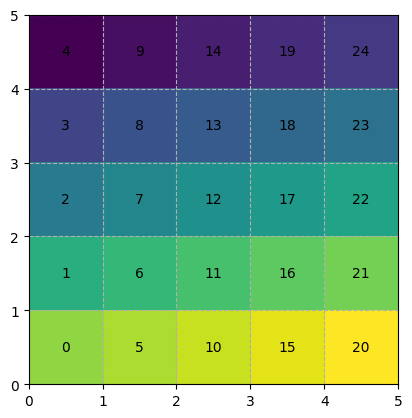

In [ ]:
e = GridWorld()
e.reset()
e.plot()

In [ ]:
def compute_returns(rewards, discount, bin_size=1):
    assert len(rewards) >= bin_size
    discounts = [discount**t for t in range(bin_size)]
    return np.array([np.dot(rewards[t+1:t+1+bin_size], discounts)
                     for t in range(len(rewards)-bin_size)])


def bin_vector(x, num_bins):
  j = int(len(x) / num_bins)
  return np.array([np.sum(x[i * j:(i + 1) * j]) for i in range(num_bins)])

# Part 1. Decision policies

In reinforcement learning a policy determines how the agent behaves. Mathematically, a policy is a mapping from states to actions $\pi : \mathcal{S} \rightarrow \mathcal{A}$. This mapping can be either deterministic or stochastic. In many cases, and particularly for the algorithms we consider, the policy is defined in terms of the value function. To familarize yourself with these ideas, you will implement several well-known decision policies.

1. A uniform random policy: $a \sim \text{Uniform}(\mathcal{A})$.
2. A greedy decision policy that breaks ties unifomly at random. Do this for Gaussian-random values.
3. An epsilon-greedy policy that takes random actions $\varepsilon$ percent of the time. Fix $\varepsilon=0.1$ for this exercise.

After many steps of experience, the distribution of state visitation counts will be proportional to the stationary distribution of the MDP. For each policy visualize the distribution of state visitation counts using the environment attribute env.counts. How do the three policies compare?

For more information on polices and value functions see section 3.5 of Sutton and Barto. Within the same test, the greedy and epsilon-greedy policies are discussed in section 2.2.

 ## Exercise: Implement decision policies.
With the provided function signatures, implement the three decision policies mentioned above.  

In [ ]:
#@title Policies (Exercise)
def random_action(actions, rs):
  """
    actions: an np array of action indices.
    rs: the np random state.
  """
  # YOUR CODE GOES HERE.
  return


def greedy_action(w, x, rs):
  """
    w: a (num_states, num_actions) jnp matrix of action values.
    x: observation vector.
    rs: the np random state.
  """
  # YOUR CODE GOES HERE.
  return


def epsilon_greedy(w, x, rs, epsilon=0.1):
  """
    w: a (num_states, num_actions) jnp matrix of action values.
    x: observation vector.
    rs: the np random state.
    epsilon: the probability of taking a random action.
  """
  # YOUR CODE GOES HERE.
  return

In [ ]:
#@title Policies (Solution)
def random_action(actions, rs):
  """
    actions: an np array of action indices.
    rs: the np random state.
  """
  return rs.choice(actions)


def greedy_action(w, x, rs):
  """
    w: a (num_states, num_actions) jnp matrix of action values.
    x: observation vector.
    rs: the np random state.
  """
  q = jnp.matmul(x, w)
  a = jnp.flatnonzero(q == jnp.max(q))
  return rs.choice(a)


def epsilon_greedy(w, x, rs, epsilon=0.1):
  """
    w: a (num_states, num_actions) jnp matrix of action values.
    x: observation vector.
    rs: the np random state.
    epsilon: the probability of taking a random action.
  """
  if rs.rand() < epsilon:
    return rs.choice(jnp.shape(w)[-1])
  return greedy_action(w, x, rs)

In [ ]:
#@title Random policy (Exercise).
env = GridWorld()
last_x_w = env.reset()

rs = np.random.RandomState(0)
actions = # YOUR CODE GOES HERE.
for _ in range(1000):
  last_action = # YOUR CODE GOES HERE.
  x_w, reward, done = env.step(last_action)

  if done:
    last_x_w = env.reset()
  else:
    last_x_w = x_w
random_state_visitation = # YOUR CODE GOES HERE.

SyntaxError: invalid syntax (ipython-input-615333177.py, line 6)

In [ ]:
#@title Random policy (Solution).
env = GridWorld()
last_x_w = env.reset()

rs = np.random.RandomState(0)
actions = np.arange(env.num_actions)
for _ in range(1000):
  last_action = random_action(actions, rs)
  x_w, reward, done = env.step(last_action)

  if done:
    last_x_w = env.reset()
  else:
    last_x_w = x_w
random_state_visitation = np.copy(env.counts)

In [ ]:
#@title Greedy policy with random values (Exercise).
env = GridWorld()
last_x_w = env.reset()

rs = np.random.RandomState(0)
random_values = # YOUR CODE GOES HERE.
for _ in range(1000):
  # YOUR CODE GOES HERE.
greedy_state_visitation = # YOUR CODE GOES HERE.

In [ ]:
#@title Greedy policy with random values (Solution).
env = GridWorld()
last_x_w = env.reset()

rs = np.random.RandomState(0)
random_values = rs.normal(size=(env.num_states, env.num_actions))
for _ in range(1000):
  last_action = greedy_action(random_values, last_x_w, rs)
  x_w, reward, done = env.step(last_action)

  if done:
    last_x_w = env.reset()
  else:
    last_x_w = x_w
greedy_state_visitation = np.copy(env.counts)

In [ ]:
#@title $\varepsilon$-Greedy policy with random values (Exercise).
env = GridWorld()
last_x_w = env.reset()

rs = np.random.RandomState(0)
random_values = # YOUR CODE GOES HERE.
for _ in range(1000):
  # YOUR CODE GOES HERE.
epsilon_greedy_state_visitation = # YOUR CODE GOES HERE.

In [ ]:
#@title $\varepsilon$-Greedy policy with random values (Solution).
env = GridWorld()
last_x_w = env.reset()

rs = np.random.RandomState(0)
random_values = rs.normal(size=(env.num_states, env.num_actions))
for _ in range(1000):
  last_action = epsilon_greedy(random_values, last_x_w, rs)
  x_w, reward, done = env.step(last_action)

  if done:
    last_x_w = env.reset()
  else:
    last_x_w = x_w
epsilon_greedy_state_visitation = np.copy(env.counts)

Plot the results with the code below.

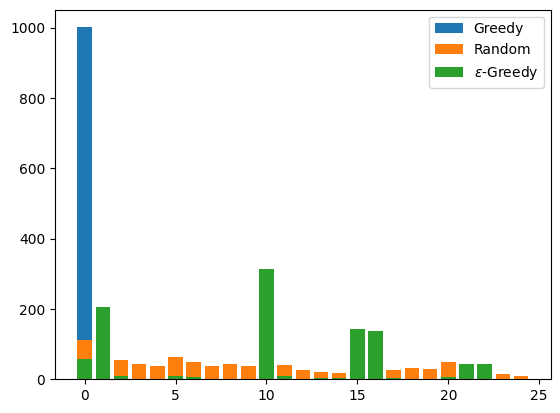

In [ ]:
plt.bar(np.arange(env.num_states), greedy_state_visitation, label='Greedy')
plt.bar(np.arange(env.num_states), random_state_visitation, label='Random')
plt.bar(np.arange(env.num_states), epsilon_greedy_state_visitation, label=r'$\varepsilon$-Greedy')
plt.legend()

## Observations (Exercise)
WRITE YOUR OBSERVATIONS HERE.

## Observations (Solution)
1. The greedy policy is deterministic, so its mass will be concentrated at one transition from the start state.
2. The Random policy will be the most diffuse, because all actions are equally likely at transition time.
3. The $\varepsilon$-greedy poilcy will be more diffuse than the greedy poilcy, since it implements some random action selection. Additionally, for Gaussian-random values, there will be points along the perimeter where this policy gets caught in self-looping transitions. This is evident from the distributions several peaks.

# Part 2. Policy Evaluation (Prediction)

When performing policy evalution, a system learns to predict the sum of future rewards that occur while following a policy $\pi$. If the experience used to learn the prediction comes from the policy itself, then we say the evaluation is on-policy. In this component you will implement Sarsa, a learning algorithm for on-policy evaluation.

The Sarsa algorithm starts with an arbitrary estimate of action values $q_\pi(s,a)$ for all $s,a$, then it uses experience gathered under $\pi$ to incrementally improve the action-value estimates. The update rule follows the method of temporal differences at each transition $s,a\rightarrow r,s',a'$, where $a,a'\sim \pi$. See section 6.4 of Sutton and Barto for more information.
$$q_\pi(s,a) \gets q_\pi(s,a) + \alpha[r +\gamma q_\pi(s',a') - q_\pi(s,a)].$$


In [ ]:
#@title Visualization code
def plot_colored_value_cell(x, y, q, ax, norm):
  scale = 0.2
  size = scale * 1

  cmap = colormaps.get_cmap('jet')

  v = np.max(q)
  color = cmap(norm(v))

  # Scale coordinates
  x_scaled = scale * x
  y_scaled = scale * y

  # Create and add the rectangle
  rect = plt.Rectangle([x_scaled, y_scaled], size, size,
                      facecolor=color,
                      edgecolor='black',
                      linewidth=0.5,
                      clip_on=False)
  ax.add_patch(rect)

  # Add centered text
  ax.text(x_scaled + size/2, y_scaled + size/2, f'{v:.2f}',
          ha='center', va='center', fontsize=8)

  return ax

def plot_arrow_value_cell(x, y, q, ax):
  scale = 0.2
  size = scale * 1

  color='white'
  head_width = .05 * scale
  head_length = .05 * scale
  q_norm = scale * .5 * q / np.sqrt(np.sum(q**2))
  x = scale * x
  y = scale * y

  rect = plt.Rectangle([x, y], size, size,
                      facecolor=color,
                      edgecolor='black',
                      clip_on=False)
  ax.add_patch(rect)
  x = x + .5 * scale
  y = y + .5 * scale

  # left
  dx = q_norm[0]
  ax.arrow(x, y, -dx, 0,
            length_includes_head=True,
            head_width=head_width,
            head_length=head_length,
            color='black')
  # up
  dy = q_norm[1]
  ax.arrow(x, y, 0, dy,
            length_includes_head=True,
            head_width=head_width,
            head_length=head_length,
            color='black')
  # right
  dx = q_norm[2]
  ax.arrow(x, y, dx, 0,
            length_includes_head=True,
            head_width=head_width,
            head_length=head_length,
            color='black')
  #down
  dy = q_norm[3]
  ax.arrow(x, y, 0, -dy,
            length_includes_head=True,
            head_width=head_width,
            head_length=head_length,
            color='black')
  return ax

def plot_greedy_cell(x, y, q, ax):
  scale = 0.2
  size = scale * 1

  color='white'
  head_width = .05 * scale
  head_length = .05 * scale
  q_norm = scale * .5 * q / np.sqrt(np.sum(q**2))
  i_greedy = np.argmax(q_norm)

  x = scale * x
  y = scale * y

  rect = plt.Rectangle([x, y], size, size,
                      facecolor=color,
                      edgecolor='black',
                      clip_on=False)
  ax.add_patch(rect)
  x = x + .5 * scale
  y = y + .5 * scale

  if i_greedy == 0:
    # left
    dx = q_norm[0]
    ax.arrow(x, y, -dx, 0,
              length_includes_head=True,
              head_width=head_width,
              head_length=head_length,
              color='black')
  elif i_greedy == 1:
    # up
    dy = q_norm[1]
    ax.arrow(x, y, 0, dy,
              length_includes_head=True,
              head_width=head_width,
              head_length=head_length,
              color='black')
  elif i_greedy == 2:
    # right
    dx = q_norm[2]
    ax.arrow(x, y, dx, 0,
              length_includes_head=True,
              head_width=head_width,
              head_length=head_length,
              color='black')
  elif i_greedy == 3:
    #down
    dy = q_norm[3]
    ax.arrow(x, y, 0, -dy,
              length_includes_head=True,
              head_width=head_width,
              head_length=head_length,
              color='black')
  return ax


def plot_qvals(env, agent, arrow_plot=False):
  qvalues = np.zeros((env.num_states, env.num_actions))
  for s in range(env.num_states):
    state = jax.nn.one_hot(s, env.num_states)
    for a in range(env.num_actions):
      qvalues[s, a] = agent.value(state, a)

  vmin, vmax = np.min(qvalues), np.max(qvalues)
  norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)

  fig, ax = plt.subplots(figsize=(5,5))
  for i in range(25):
    x, y = env.get_xy(i)
    if arrow_plot:
      plot_arrow_value_cell(x, y, qvalues[i], ax)
    else:
      plot_colored_value_cell(x, y, qvalues[i], ax, norm)
  ax.set_axis_off()
  plt.plot()


def plot_greedy_policy(env, agent):
  qvalues = np.zeros((env.num_states, env.num_actions))
  for s in range(env.num_states):
    state = jax.nn.one_hot(s, env.num_states)
    for a in range(env.num_actions):
      qvalues[s, a] = agent.value(state, a)

  fig, ax = plt.subplots(figsize=(5,5))
  for i in range(25):
    x, y = env.get_xy(i)
    plot_greedy_cell(x, y, qvalues[i], ax)

  ax.set_axis_off()
  plt.plot()


 ## Exercise: Sarsa Implementation.

 Implement the Sarsa algorithm.

In [ ]:
#@title Sarsa (Exercise)
class Sarsa(object):
  """Sarsa."""
  def __init__(self,
               first_x_w,
               num_actions,
               discount=0.9,
               alpha_w=1.):
    self.last_x_w = first_x_w
    self.num_actions = num_actions
    self.w_q = jnp.zeros((len(self.last_x_w), self.num_actions))
    self.discount = discount
    self.alpha_w= alpha_w

  def update(self, last_x_w, last_a, reward, x_w, a, done):
    # YOUR CODE GOES HERE.

  def value(self, x_w, action):
    # YOUR CODE GOES HERE.
    return

IndentationError: expected an indented block after function definition on line 15 (ipython-input-2925056891.py, line 18)

In [ ]:
#@title Sarsa (Solution)
class Sarsa(object):
  """Sarsa."""
  def __init__(self,
               first_x_w,
               num_actions,
               discount=0.9,
               alpha_w=1.):
    self.last_x_w = first_x_w
    self.num_actions = num_actions
    self.w_q = jnp.zeros((len(self.last_x_w), self.num_actions))
    self.discount = discount
    self.alpha_w= alpha_w

  def update(self, last_x_w, last_a, reward, x_w, a, done):
    discount = 0. if done else self.discount
    w_a = _update_sarsa(last_x_w, reward, x_w,
                        self.w_q[:, last_a], self.w_q[:, a],
                        discount,
                        self.alpha_w)
    self.w_q = self.w_q.at[:, last_a].set(w_a)

  def value(self, x_w, action):
    return jnp.dot(self.w_q[:, action], x_w)


@jax.jit
def _update_sarsa(last_x_w, reward, x_w, last_w_q_a, w_q_a, discount, alpha_w):
  target = reward + discount * jnp.dot(w_q_a, x_w)
  td_error = target - jnp.dot(last_w_q_a, last_x_w)
  last_w_q_a += alpha_w * td_error * last_x_w
  return last_w_q_a

## Exercise: Policy evaluation with Sarsa.

Use your implementation of Sarsa to evaluate the actions of a random policy.

In [ ]:
env = GridWorld()
last_x_w = env.reset()
agent = Sarsa(first_x_w=last_x_w, num_actions=env.num_actions)

rs = np.random.RandomState(0)
actions = np.arange(env.num_actions)
steps = []
ep_steps = 0.
for t in range(1000):
  last_action = random_action(actions, rs)
  x_w, reward, done = env.step(last_action)
  action = random_action(actions, rs)
  agent.update(last_x_w, last_action, reward, x_w, action, done)

  ep_steps += 1
  if done:
    last_x_w = env.reset()
    steps.append(ep_steps)
    ep_steps = 0.
  else:
    last_x_w = x_w

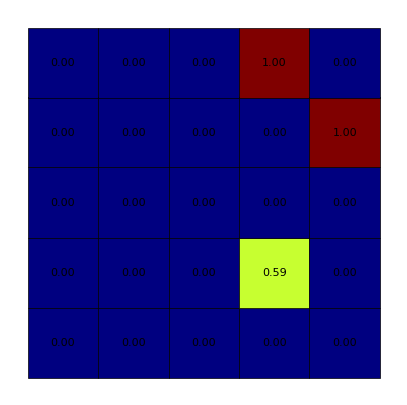

In [ ]:
plot_qvals(env, agent)

## Exercise: On-policy control with Sarsa.

Sarsa can also be used as an on-policy control algorithm. One case in which this occurs is under the $\varepsilon$-greedy policy.

At any given time, the learner selects the best action according to the current estimate of the action-value function, with probability $1-\varepsilon$. Then $\varepsilon$ percent of the time the learner acts randomly.

Throughout this process, the values that Sarsa learns become increasingly accurate. This causes the policy that it evaluates to change. Eventually, the process stabilizes (at least in this domain) when the values reflect the true greedy actions. These will be optimal for achieving high return.

Use your implementation of Sarsa to evaluate the actions of an epsilon-greedy policy.


In [ ]:
env = GridWorld()
last_x_w = env.reset()
agent = Sarsa(first_x_w=last_x_w, num_actions=env.num_actions)

rs = np.random.RandomState(0)
steps = []
ep_steps = 0.
for t in range(10000):
  last_action = epsilon_greedy(agent.w_q, last_x_w, rs)
  x_w, reward, done = env.step(last_action)
  action = epsilon_greedy(agent.w_q, x_w, rs)
  agent.update(last_x_w, last_action, reward, x_w, action, done)

  ep_steps += 1
  if done:
    last_x_w = env.reset()
    steps.append(ep_steps)
    ep_steps = 0.
  else:
    last_x_w = x_w

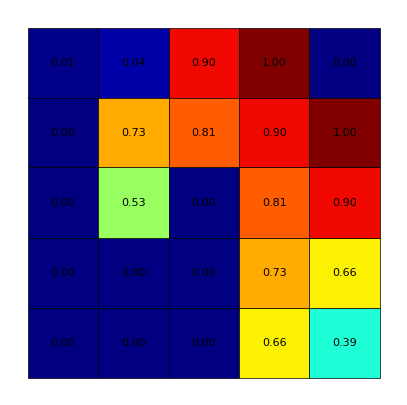

In [ ]:
plot_qvals(env, agent)

# Part 3. Policy Iteration (Control)

Reinforcement learning is renowed for having general-purpose algorithms that can learn useful decision policies without access to a transition model. Algorithms of this type sample transitions by directly interacting with an environment: taking actions and observing the outcomes. With this feedback, a learning system can iteratively evaluate and improve its policy, so that in the long term, its actions lead to the maximum amount of future reward.

Here we focus on an off-policy algorithm for control. Off-policy algorithms use experience gathered under a behavior policy, $\pi$, to update a target policy $\pi^*$. The Q-Learning algorithm (Watkins 1989) considers the greedy target policy and applies the method of temporal differences to update its action-value estimates. The update rule is given below.

$$q(s,a) \gets q(s,a) + \alpha[r+\gamma \max_{a'\in\mathscr{A}} q(s',a') - q(s,a)].$$



 ## Exercise: Q-Learning implementation

Implement Q-learning

In [ ]:
#@title Q-Learning (Exercise)
class QLearning(object):
  """QLearning."""
  def __init__(self,
               first_x_w,
               num_actions,
               discount=0.9,
               alpha_w=1.):
    self.last_x_w = first_x_w
    self.num_actions = num_actions
    self.w_q = jnp.zeros((len(self.last_x_w), self.num_actions))
    self.discount = discount
    self.alpha_w= alpha_w

  def update(self, x_w, last_a, reward, done):
    # YOUR CODE GOES HERE.

  def value(self, x_w, action):
    # YOUR CODE GOES HERE.
    return

IndentationError: expected an indented block after function definition on line 15 (ipython-input-982410278.py, line 18)

In [ ]:
#@title Q-Learning (Solution)
class QLearning(object):
  """QLearning."""
  def __init__(self,
               first_x_w,
               num_actions,
               discount=0.9,
               alpha_w=1.):
    self.last_x_w = first_x_w
    self.num_actions = num_actions
    self.w_q = jnp.zeros((len(self.last_x_w), self.num_actions))
    self.discount = discount
    self.alpha_w= alpha_w

  def update(self, last_x_w, last_a, reward, x_w, done):
    a = greedy_action(self.w_q, x_w, np.random.RandomState(0))
    discount = 0. if done else self.discount
    w_a = _update_ql(last_x_w, reward, x_w,
                     self.w_q[:, last_a], self.w_q[:, a],
                     discount,
                     self.alpha_w)
    self.w_q = self.w_q.at[:, last_a].set(w_a)

  def value(self, x_w, action):
    return jnp.dot(self.w_q[:, action], x_w)


@jax.jit
def _update_ql(last_x_w, reward, x_w, last_w_q_a, w_q_a, discount, alpha_w):
  target = reward + discount * jnp.dot(w_q_a, x_w)
  td_error = target - jnp.dot(last_w_q_a, last_x_w)
  last_w_q_a += alpha_w * td_error * last_x_w
  return last_w_q_a

In [ ]:
env = GridWorld()
last_x_w = env.reset()
agent = QLearning(first_x_w=last_x_w, num_actions=env.num_actions)

rs = np.random.RandomState(0)
steps = []
ep_steps = 0.
for t in range(1000):
  last_action = epsilon_greedy(agent.w_q, last_x_w, rs)
  x_w, reward, done = env.step(last_action)
  agent.update(last_x_w, last_action, reward, x_w, done)

  ep_steps += 1
  if done:
    last_x_w = env.reset()
    steps.append(ep_steps)
    ep_steps = 0.
  else:
    last_x_w = x_w

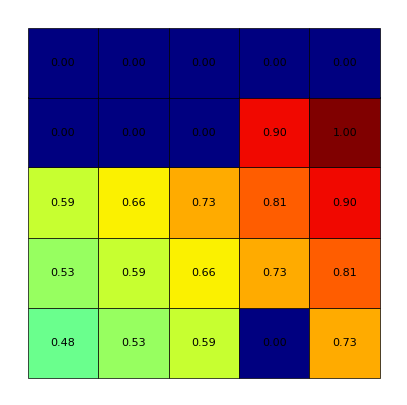

In [ ]:
plot_qvals(env, agent)

/tmp/ipython-input-3105019730.py:85: RuntimeWarning: invalid value encountered in divide
  q_norm = scale * .5 * q / np.sqrt(np.sum(q**2))


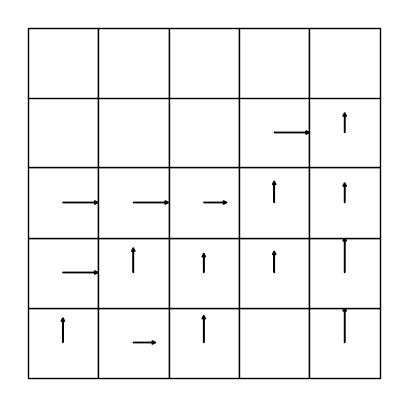

In [ ]:
plot_greedy_policy(env, agent)

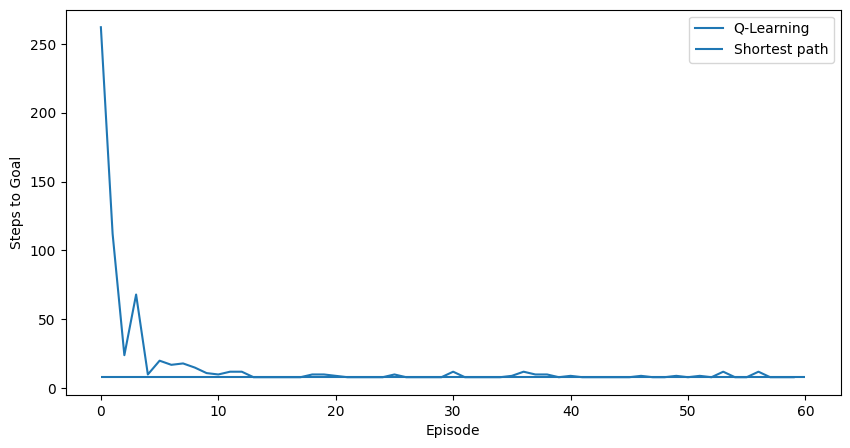

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(len(steps)), steps, label='Q-Learning')
ax.hlines(y=8, xmin=0, xmax=len(steps), label='Shortest path')
ax.set_xlabel('Episode')
ax.set_ylabel('Steps to Goal')
ax.legend()

 ## Exercise: Exploration parameter sensitivity.

The parameter $\varepsilon$ is said to control the amount of exploration the learning system experiences. In this context, $\varepsilon$ specifically controls the probability of taking an action uniformly at random.

In this exercise, we would like to tune the exploration parameter to acheive better learning performance. Choose an aggregate performance metric, such as the average number of steps to the goal, then evaluate the metric for several different values of $\varepsilon$, e.g. $\varepsilon \in \{0, 0.1, 0.2, 0.3, \cdots, 1\}$. What value of $\varepsilon$ achieved the best aggregate performance? Construct a sensitivy curve by plotting $\varepsilon$ versus aggregate performance. Comment on the profile of the curve; explain the behavior at the extreme values. Do you believe that further improvements would be possible with a different evaluation?

In [ ]:
#@title Exercise

# YOUR CODE GOES HERE.

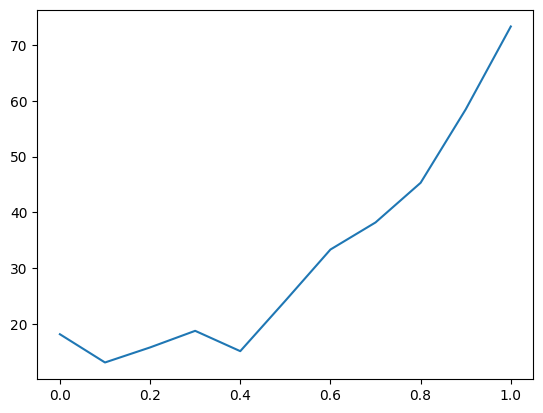

In [ ]:
#@title Solution
env = GridWorld()

epsilon_range = np.linspace(0,1,11)
rs = np.random.RandomState(0)
auc = []
for epsilon in epsilon_range:
  steps = []; ep_steps = 0.
  last_x_w = env.reset()
  agent = QLearning(first_x_w=last_x_w, num_actions=env.num_actions)
  for t in range(1000):
    last_action = epsilon_greedy(agent.w_q, last_x_w, rs, epsilon)
    x_w, reward, done = env.step(last_action)
    agent.update(last_x_w, last_action, reward, x_w, done)

    ep_steps += 1
    if done:
      last_x_w = env.reset()
      steps.append(ep_steps)
      ep_steps = 0.
    else:
      last_x_w = x_w
  auc.append(np.mean(np.array(steps)))

plt.plot(epsilon_range, auc)

 ## Exercise: Step-size sensitivity.
The stepsize $\alpha$ controls the size of the learning system's corrections. This can have a significant effect on the system's overall adaptibility: its rate of learning and its longterm stability.

In this exercise we would like you to fix the exploration parameter to $\varepsilon =0.1$ and repeat the previous sensitivity analysis for the step size. Using the step size in place of the exploration parameter, use the same aggregate performance metric to evaluate several different values of $\alpha$. For example, make sure your evaluation range captures the extreme cases of $\alpha=0$ and $\alpha=1$, e.g. $\alpha\in\{0,10^{-3}, 10^{-2}, 10^{-1}, 1\}$. Which value of $\alpha$ demonstrated the highest aggregate performance?


In [ ]:
#@title Exercise

# YOUR CODE GOES HERE.

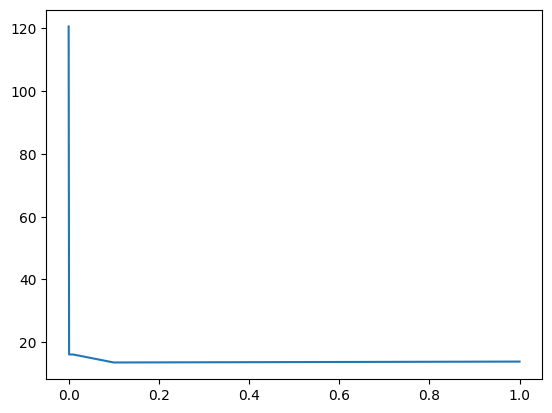

In [ ]:
#@title Solution
env = GridWorld()

step_size_range = [0, 1e-3, 1e-2, 1e-1, 1]
rs = np.random.RandomState(0)
auc = []
for alpha_w in step_size_range:
  steps = []; ep_steps = 0.
  last_x_w = env.reset()
  agent = QLearning(first_x_w=last_x_w,
                    num_actions=env.num_actions,
                    alpha_w=alpha_w)
  for t in range(1000):
    last_action = epsilon_greedy(agent.w_q, last_x_w, rs)
    x_w, reward, done = env.step(last_action)
    agent.update(last_x_w, last_action, reward, x_w, done)

    ep_steps += 1
    if done:
      last_x_w = env.reset()
      steps.append(ep_steps)
      ep_steps = 0.
    else:
      last_x_w = x_w
  auc.append(np.mean(np.array(steps)))

plt.plot(step_size_range, auc)

## Exercise: Stochastic transitions.
The previous exercises took place in a deterministic environment. In reality, most environments are stochastic, and these are also some of the most interesting application domains of RL.

Point out the differences from the previously studied phenomena. This should have been observed in your results from the previous two exercises. Repeat the above analysis for the stochastic domain. How did the results change?

Now that the domain is stochastic, it does not suffice to look at the performance of just a single trial. Run 30 trials with different seeds and plot the average performance as well as the standard error confidence intervals.

In [ ]:
#@title Exercise

# YOUR CODE GOES HERE.

In [ ]:
#@title Solution
env = GridWorld(stochastic=True)

trial_steps = []
for seed in range(30):
  rs = np.random.RandomState(seed)
  steps = []; ep_steps = 0.
  last_x_w = env.reset()
  agent = QLearning(first_x_w=last_x_w,
                    num_actions=env.num_actions,
                    alpha_w=alpha_w)
  for _ in range(50):
    while True:
      last_action = epsilon_greedy(agent.w_q, last_x_w, rs)
      x_w, reward, done = env.step(last_action)
      agent.update(last_x_w, last_action, reward, x_w, done)

      ep_steps += 1
      if done:
        last_x_w = env.reset()
        steps.append(ep_steps)
        ep_steps = 0.
        break
      else:
        last_x_w = x_w
  trial_steps.append(np.array(steps))

Use the code below to plot learning performance.

In [ ]:
def mean_confidence_interval(data):
    import scipy as sp
    """Compute confidence interval from sample data."""
    num_samp = len(data)
    mean = np.array(np.mean(data, axis=0))
    se = sp.stats.sem(data, axis=0)
    return mean, se

<ErrorbarContainer object of 3 artists>

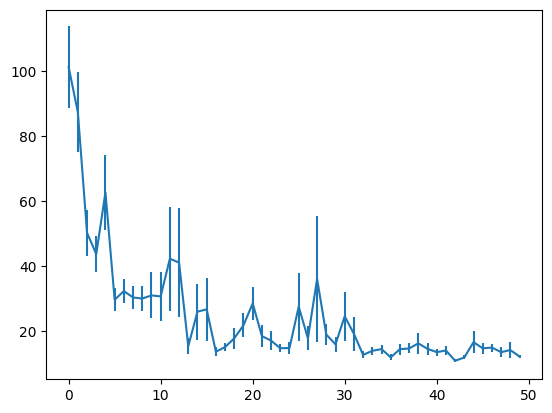

In [ ]:
data = np.array(trial_steps)
mean_steps, se = mean_confidence_interval(data)
plt.errorbar(np.arange(len(mean_steps)), mean_steps, yerr=se)

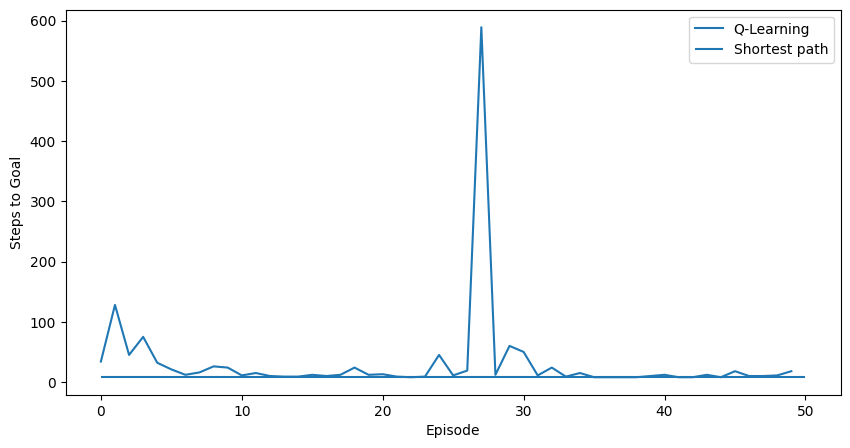

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(len(steps)), steps, label='Q-Learning')
ax.hlines(y=8, xmin=0, xmax=len(steps), label='Shortest path')
ax.set_xlabel('Episode')
ax.set_ylabel('Steps to Goal')
ax.legend()

# Part 4. Continuous control with PPO.

This next part with guide you through a control problem using the PPO algorithm from the [Stable Baselines repository](https://github.com/hill-a/stable-baselines).

The code is adapted from the [Stable Baselines tutorial](https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/master/stable_baselines_getting_started.ipynb).


## Introduction

In this notebook, you will learn how to create a RL model, train it and evaluate it.


## Install Dependencies and Stable Baselines Using Pip

List of full dependencies can be found in the [README](https://github.com/hill-a/stable-baselines).

```
sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev
```


```
pip install stable-baselines[mpi]
```

In [ ]:
# Install system dependencies for rendering (optional but recommended)
!apt-get update && apt-get install -y ffmpeg freeglut3-dev xvfb

# Install Stable Baselines3 with extra components
!pip install "stable-baselines3[extra]"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [354 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,302 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,618 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu ja

In [ ]:
import stable_baselines3
print(f"SB3 version: {stable_baselines3.__version__}")

SB3 version: 2.7.1


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Old - Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines[mpi]==2.10.2
from IPython.display import clear_output
clear_output()

ValueError: Tensorflow 1 is unsupported in Colab.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

In [ ]:
# Old
import stable_baselines
stable_baselines.__version__

ModuleNotFoundError: No module named 'stable_baselines'

Stable-Baselines works on environments that follow the [gym interface](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html).
You can find a list of available environments [here](https://gym.openai.com/envs/#classic_control).

It is also recommended to check the [source code](https://github.com/openai/gym) to learn more about the observation and action space of each env, as gym does not have a proper documentation.
Not all algorithms can work with all action spaces, you can find more in this [recap table](https://stable-baselines.readthedocs.io/en/master/guide/algos.html).

## Imports

In [ ]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO

## Create the Gym env and instantiate the agent

For this example, we will use CartPole environment, a classic control problem.

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright.

Cartpole environment: [link](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)

Note: vectorized environments allow to easily multiprocess training. In this example, we are using only one process, hence the `DummyVecEnv`.

We chose the `MlpPolicy` because input of `CartPole` is a feature vector, not images.

The type of action to use (discrete/continuous) will be automatically deduced from the environment action space


Here we are using the [Proximal Policy Optimization](https://arxiv.org/abs/1707.06347) algorithm, which is an Actor-Critic method; it uses a value function to improve the policy gradient descent.

It combines ideas from [A2C](https://arxiv.org/abs/1602.01783) (having multiple workers and using an entropy bonus for exploration) and [TRPO](https://arxiv.org/abs/1502.05477) (it uses a trust region to improve stability and avoid catastrophic drops in performance).

PPO is an on-policy algorithm, which means that the trajectories used to update the networks must be collected using the latest policy.
It is usually less sample efficient than off-policy alorithms like [DQN](https://arxiv.org/abs/1312.5602), [SAC](https://arxiv.org/abs/1801.01290) or [TD3](https://arxiv.org/pdf/1802.09477), but is much faster regarding wall-clock time.


## Exercise: Sweeps of architecture size and step size.

> `verbose=1` prints the output as the model learns

> `learning_rate`: (float or callable) The step size, it can be a function. See
https://github.com/hill-a/stable-baselines/blob/master/stable_baselines/ppo2/ppo2.py
for further details.

> `net_arch`: parameter allows to specify the amount and size of the hidden layers
and how many of them are shared between the policy network and the value
network. See
https://github.com/hill-a/stable-baselines/blob/master/stable_baselines/common/policies.py
for further details.

**Adjust the step size and architecture** and observe the differences in learning performance.

In [ ]:
model = PPO("MlpPolicy", "CartPole-v1", verbose=0,
            learning_rate=2.5e-4,
            policy_kwargs=dict(net_arch=[64, 64]))

We create a helper function to evaluate the agent:

In [ ]:
def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

In fact, Stable-Baselines already provides you with that helper:

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

Let's evaluate the un-trained agent, this should be a random agent.

In [ ]:
import gymnasium as gym
from stable_baselines3.common.evaluation import evaluate_policy

# 1. Create env and model
eval_env = gym.make("CartPole-v1")

# 2. Evaluate the initialized agent (usually done after training)
# n_eval_episodes=100 means it will run 100 games and average the results
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=100)

print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 66.76 +/- 30.27


## Train the agent and evaluate it

In [ ]:
# Train the agent for 10000 steps
model.learn(total_timesteps=10000)

In [ ]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:443.97 +/- 84.57


The `mean_reward` above is quite low for this task. Your challenge in this exercise is:

## Exercise: Try and adjust the parameters above to get the highest possible mean reward.
* What parameter combinations worked well?
* What does the performance do as you keep changing a parameter in one direction? For example, try running with:
`learning_rate: 1e-6, 1e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1`.
* Try changing the `arch` to be more/less powerful. How does this impact performance? Does it saturate? You can try using the colab magic `%%timeit` to see the impact on training speed.

## `STOP HERE`
If, after the session, you want to try and visualise the models, you can try and run the code below.

## Prepare video recording

**Note:** This will _NOT_ work on a Google Colaboratory. If you run this locally, you can try and get this working.

In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
import base64
from IPython import display as ipythondisplay
from pathlib import Path

def record_video(env_id, model, video_length=500, prefix="ppo-video"):
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])

    # Wrap the environment to record video
    eval_env = VecVideoRecorder(eval_env, video_folder="./videos/",
                                record_video_trigger=lambda step: step == 0,
                                video_length=video_length,
                                name_prefix=prefix)

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _ = eval_env.step(action)

    eval_env.close()

# Helper function to show the video in Colab
def show_videos(video_path):
    video_file = list(Path(video_path).glob("*.mp4"))[0]
    video = open(video_file, 'rb').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(ipythondisplay.HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))

# Run the recording
record_video("CartPole-v1", model, video_length=200)
show_videos("./videos")

/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Saving video to /content/videos/ppo-video-step-0-to-step-200.mp4


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Moviepy - Building video /content/videos/ppo-video-step-0-to-step-200.mp4.
Moviepy - Writing video /content/videos/ppo-video-step-0-to-step-200.mp4



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Moviepy - Done !
Moviepy - video ready /content/videos/ppo-video-step-0-to-step-200.mp4


# Want to learn more?

Many of these references were originally compiled by Feryal Behbahani and Gheorghe Comanici [[here](https://colab.research.google.com/github/eemlcommunity/PracticalSessions2020/blob/master/rl/EEML2020_RL_Tutorial.ipynb#scrollTo=XWqlIWbwN7Mk)].

Books and lecture notes
*   [Reinforcement Learning: an Introduction by Sutton & Barto](http://incompleteideas.net/book/RLbook2018.pdf)
* [Algorithms for Reinforcement Learning by Csaba Szepesvari](https://sites.ualberta.ca/~szepesva/papers/RLAlgsInMDPs.pdf)

Lectures and course
*   [Reinforcement learning course at UCL by David Silver](https://www.youtube.com/playlist?list=PLzuuYNsE1EZAXYR4FJ75jcJseBmo4KQ9-)
*   [Reinforcement learning course by UCL & DeepMind](https://www.youtube.com/playlist?list=PLqYmG7hTraZBKeNJ-JE_eyJHZ7XgBoAyb)
*   [Reinforcement learning course at Stanford by Emma Brunskill](https://www.youtube.com/playlist?list=PLoROMvodv4rOSOPzutgyCTapiGlY2Nd8u)
*   [Reinforcement learning course on U Alberta Coursera by Martha White & Adam White](https://www.coursera.org/specializations/reinforcement-learning)
*   [Reinforcement learning lecture at NPTEL by Balaraman Ravindran](https://youtu.be/YaPSPu7K9S0)

More practical:
* [Spinning Up in Deep RL by Josh Achiam](https://spinningup.openai.com/en/latest/)
* [An interactive tutorial on TD learning by Andrej Karpathy](https://cs.stanford.edu/people/karpathy/reinforcejs/gridworld_td.html)


